# Previsão Climática
## Nome: Rodrigo de Lima Florindo
## Matrícula: 101809

Notas:
- Para executar corretamente este projeto, é necessário baixar manualmente o seguinte conjunto de dados: “https://www.kaggle.com/datasets/mnassrib/jena-climate?resource=download” e colocar na pasta dataset.
- A seguir, todas as perguntas do projeto 5 são respondidas nos blocos de texto do tipo markdown.

1. **Baixe o dataset Jena Climate, disponível em: https://www.kaggle.com/datasets/mnassrib/jena-climate.** (Rodrigo): Os dados foram baixados manualmente para a pasta `dataset`.

2. **Faça a indexação dos dados temporalmente e considere somente a variável Temperatura.** (Rodrigo): No código a seguir, lê-se o dataset `jena_climate_2009_2016.csv` e então seleciona-se e indexa-se a temperatura com relação ao tempo. Apenas os dados dos últimos 3 anos foram usados, a fim de evitar tempos de treinamento excessivamente longo nos modelos discutidos.

            Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0 2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1 2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2 2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3 2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4 2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.7

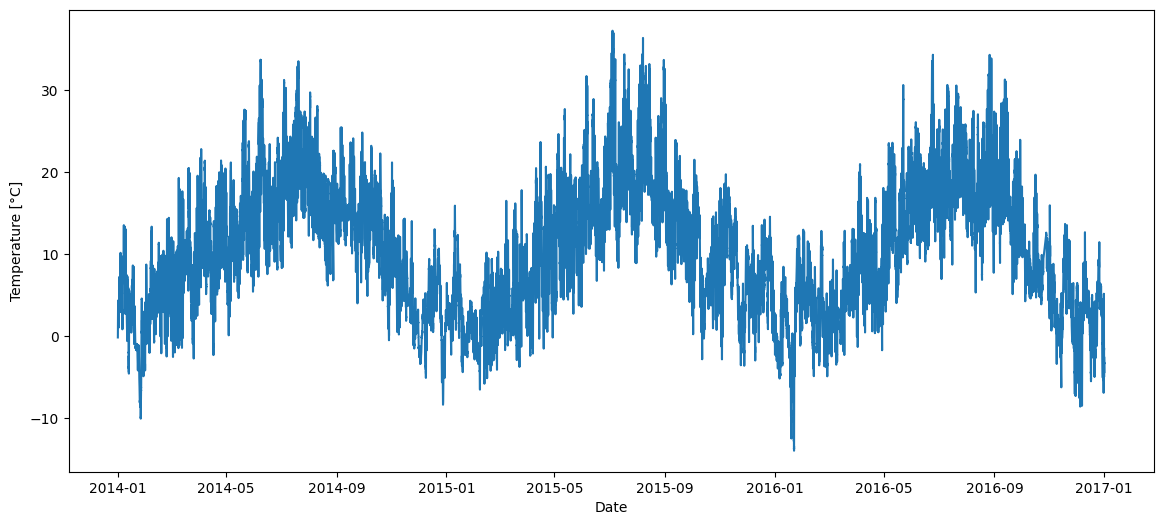

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/jena_climate_2009_2016.csv", parse_dates=["Date Time"])
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")

cutoff = df["Date Time"].max() - pd.DateOffset(years=3)
df_cut = df[df["Date Time"] >= cutoff]

# first rows
print(df.head())
# column types, counts
print(df.info())
# quick stats
print(df.describe())

# choose the column you need
temperature = df_cut["T (degC)"] 
time = df_cut["Date Time"] 

temp_with_time = pd.DataFrame({
    "Date Time": time,
    "Temperature": temperature,
}).set_index("Date Time")

print(temp_with_time.head())

plt.figure(figsize=(14,6))
plt.plot(temp_with_time)
plt.ylabel('Temperature [°C]')
plt.xlabel('Date')
plt.show()

3. **Particione a base de dados sendo 80% dos dados para treinar, 15% para validar e 5% para testar. Lembre-se de manter a sequência temporal, ou seja, configure shuffle = 0.** (Rodrigo): A seguir, implementa-se a separação dos grupos de dados de treinamento, validação e de teste.

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler

n = len(df_cut)
train_end = int(n * 0.80)
val_end = train_end + int(n * 0.15)

train_df = df_cut.iloc[:train_end]
val_df = df_cut.iloc[train_end:val_end]
test_df = df_cut.iloc[val_end:]

scaler = StandardScaler()
train_series = scaler.fit_transform(train_df[["T (degC)"]])
val_series   = scaler.transform(val_df[["T (degC)"]])
test_series  = scaler.transform(test_df[["T (degC)"]])

print(len(train_df), len(val_df), len(test_df))

def make_windows(series_df, past_window=72):
    series = series_df["T (degC)"].to_numpy()
    X, y = [], []
    for i in range(len(series) - past_window):
        X.append(series[i:i+past_window])
        y.append(series[i+past_window])
    return np.array(X), np.array(y)

PAST_WINDOW = 72

X_train, y_train = make_windows(train_df, PAST_WINDOW)
X_val,   y_val   = make_windows(val_df, PAST_WINDOW)
X_test,  y_test  = make_windows(test_df, PAST_WINDOW)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

125973 23620 7874
(125901, 72) (125901,)
(23548, 72) (23548,)
(7802, 72) (7802,)


4. **Implemente uma rede recorrente do tipo LSTM ou GRU capaz de receber a série temporal da variável temperatura e prever a temperatura da próxima amostra (próximos 10 minutos).** (Rodrigo): A seguir, implementa-se uma rede recorrente do tipo LSTM para a previsão da série temporal de temperatura usando o Keras.

In [3]:
from tensorflow import keras
from keras import layers

base_model = keras.Sequential([
    layers.Input(shape=(PAST_WINDOW, 1)),
    layers.LSTM(64),                     # or layers.GRU(64)
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

base_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    loss=keras.losses.MeanAbsoluteError(reduction="sum_over_batch_size", name="mean_absolute_error", dtype=None),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

base_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
]

base_history = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=callbacks,
    shuffle=False   # keep chronological ordering
)

2025-10-31 17:36:52.929921: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-31 17:36:52.956862: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 17:36:54.221867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-31 17:36:57.073255: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 153s 38ms/step - loss: 1.0259 - root_mean_squared_error: 1.7776 - val_loss: 1.2375 - val_root_mean_squared_error: 1.7335
Epoch 2/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 101s 26ms/step - loss: 0.4451 - root_mean_squared_error: 0.8160 - val_loss: 0.8274 - val_root_mean_squared_error: 1.1771
Epoch 3/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 89s 23ms/step - loss: 0.3499 - root_mean_squared_error: 0.6478 - val_loss: 0.7173 - val_root_mean_squared_error: 1.0696
Epoch 4/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 85s 22ms/step - loss: 0.3072 - root_mean_squared_error: 0.5607 - val_loss: 0.6111 - val_root_mean_squared_error: 0.8500
Epoch 5/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 0.2784 - root_mean_squared_error: 0.5011 - val_loss: 0.6675 - val_root_mean_squared_error: 0.9025
Epoch 6/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - loss: 0.2734 - root_mean_squared_error: 0.4811 - val_loss: 0.6630 - val_root_mean_squared_error: 0.8964
Epoch 7/10
3935/3935 ━━━━━

In [4]:
def plot_learning(history):
    history_dict = history.history
    epochs = range(1, len(history_dict["loss"]) + 1)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle("Training History")

    axes[0].plot(epochs, history_dict["loss"], label="Train Loss",
                color="tab:blue", linewidth=1.5)
    axes[0].plot(epochs, history_dict["val_loss"], label="Val Loss",
                color="tab:orange", linewidth=1.5)
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", linewidth=0.5, alpha=0.4)

    axes[1].plot(epochs, history_dict["root_mean_squared_error"], label="Train RMSE",
                color="tab:green", linewidth=1.5)
    axes[1].plot(epochs, history_dict["val_root_mean_squared_error"], label="Val RMSE",
                color="tab:red", linewidth=1.5)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("RMSE")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", linewidth=0.5, alpha=0.4)

    plt.tight_layout()
    plt.show()
def evaluate_test(model, X_test, y_test, future_window=None, horizon_to_plot=0, step_minutes=10):
    results = model.evaluate(X_test, y_test)
    if isinstance(results, (list, tuple)):
        test_rmse = results[1]
    else:
        test_rmse = results
    print(f"Test RMSE (standardized): {test_rmse:.4f}")

    pred_scaled = model.predict(X_test)
    pred_scaled = np.array(pred_scaled)
    if pred_scaled.ndim == 1:
        pred_scaled = pred_scaled[:, np.newaxis]

    y_test_scaled = np.array(y_test)
    if y_test_scaled.ndim == 1:
        y_test_scaled = y_test_scaled[:, np.newaxis]

    if future_window is None:
        future_window = pred_scaled.shape[1]

    pred_temp = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(-1, future_window)
    y_test_temp = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).reshape(-1, future_window)

    plt.figure(figsize=(10, 4))
    if future_window == 1:
        plt.plot(y_test_temp[:500, 0], label="True")
        plt.plot(pred_temp[:500, 0], label="Predicted")
        plt.title("Temperature: next-step forecast")
    else:
        horizon_to_plot = min(horizon_to_plot, future_window - 1)
        horizon_minutes = (horizon_to_plot + 1) * step_minutes
        plt.plot(y_test_temp[:500, horizon_to_plot], label=f"True (t+{horizon_minutes} min)")
        plt.plot(pred_temp[:500, horizon_to_plot], label=f"Predicted (t+{horizon_minutes} min)")
        plt.title(f"Temperature forecast ({future_window} steps ahead)")
    plt.legend()
    plt.show()


(Rodrigo): Disponibilizamos as curvas de aprendizado e do *Root Mean Square Error* (RMSE) para os grupos de dados de treinamento e de validação. Pelos resultados, podemos observar que o modelo aprendeu adequadamente a realizar predições, evitando *overfitting*, visto que as curvas de perda/custo e de RMSE diminuiram a cada época de treinamento e que não existe uma discrepância grande entre as curvas de treinamento e de validação para ambos os casos. O RMSE dos dados de teste obtido foi de 0.2918.

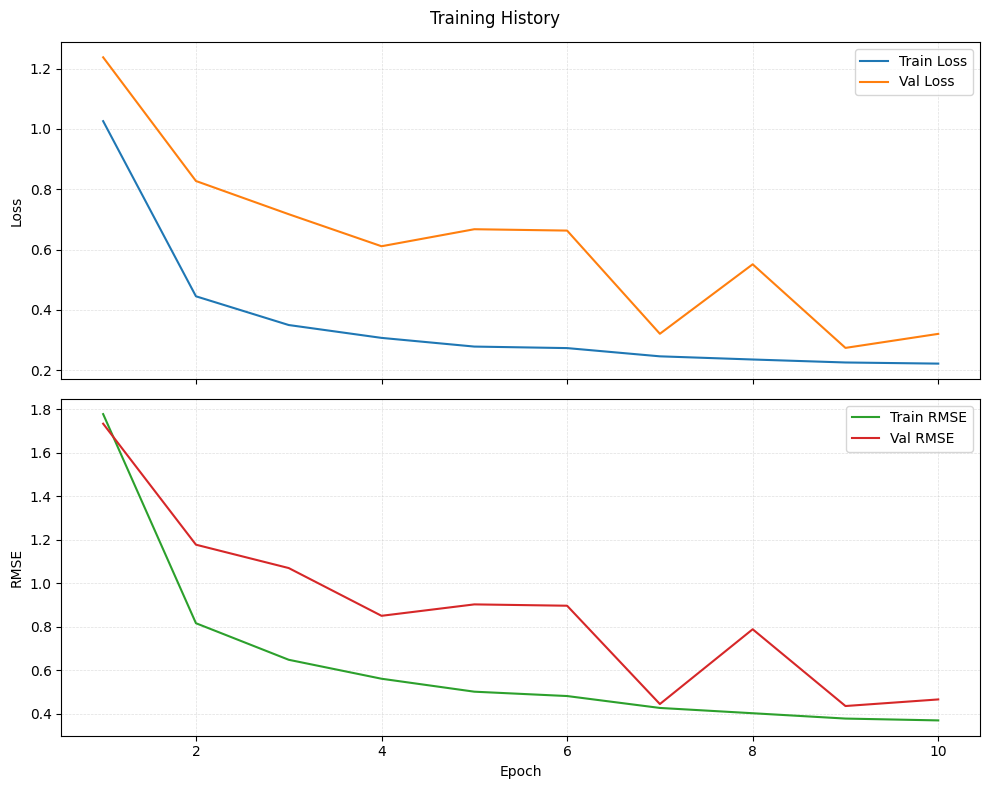

In [5]:
plot_learning(base_history)

(Rodrigo): Analisando o RMSE escalonado do grupo de dados de teste, e observando o plot das predições feita pela rede LSTM e os dados reais (True), é possível inferir que as predições do modelo são muito próximas dos dados reais, o que indica uma performance adequada do modelo proposto.

244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2030 - root_mean_squared_error: 0.2918
Test RMSE (standardized): 0.2918
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


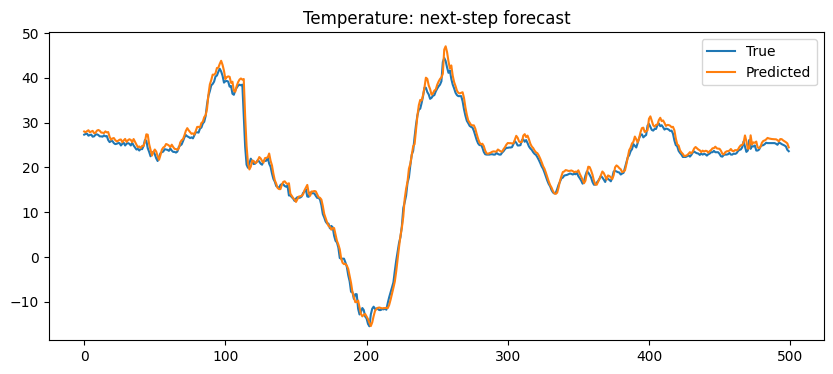

In [6]:
evaluate_test(base_model, X_test, y_test)

5. **Varie os parâmetros da rede e verifique quais impactos são causados no erro de predição da temperatura na base de teste. Considere: Número de unidades de memórias da LSTM ou da GRU, Inserir camadas de Dropout, Técnicas de otimização, Função de perda, etc.** (Rodrigo): A seguir, é implementado um outro modelo de machine learning baseado em LSTM com 128 unidades de treinamento, uma camada de dropout, função de ativação sigmoidal, otimizador adam e função de custo de erro quadrático médio.

In [7]:
variant_model = keras.Sequential([
    layers.Input(shape=(PAST_WINDOW, 1)),
    layers.LSTM(128),
    layers.Dropout(0.2),
    layers.Dense(32, activation="sigmoid"),
    layers.Dense(1)
])

variant_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError()]
)

variant_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
]

variant_history = variant_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=callbacks,
    shuffle=False   # keep chronological ordering
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,721 (276.25 KB)

 Trainable params: 70,721 (276.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 134s 34ms/step - loss: 7.5168 - root_mean_squared_error: 2.7417 - val_loss: 1.9452 - val_root_mean_squared_error: 1.3947
Epoch 2/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 132s 34ms/step - loss: 0.5289 - root_mean_squared_error: 0.7272 - val_loss: 0.2606 - val_root_mean_squared_error: 0.5105
Epoch 3/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 152s 39ms/step - loss: 0.2916 - root_mean_squared_error: 0.5400 - val_loss: 0.4320 - val_root_mean_squared_error: 0.6573
Epoch 4/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 163s 42ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833 - val_loss: 0.2807 - val_root_mean_squared_error: 0.5298
Epoch 5/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 143s 36ms/step - loss: 0.2067 - root_mean_squared_error: 0.4546 - val_loss: 0.2749 - val_root_mean_squared_error: 0.5243
Epoch 6/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 115s 29ms/step - loss: 0.1829 - root_mean_squared_error: 0.4276 - val_loss: 0.2181 - val_root_mean_squared_error: 0.4670
Epoch 7/10
3935/3935 ━

(Rodrigo): Pelas curvas de aprendizado, do RMSE e das previsões feitas usando o modelo treinado, podemos concluir que houve um overfitting nas últimas três épocas de treinamento do modelo, o que resultou em uma pior performance se comparado ao modelo anterior. O RMSE do grupo de dados de teste foi de 0.3559.

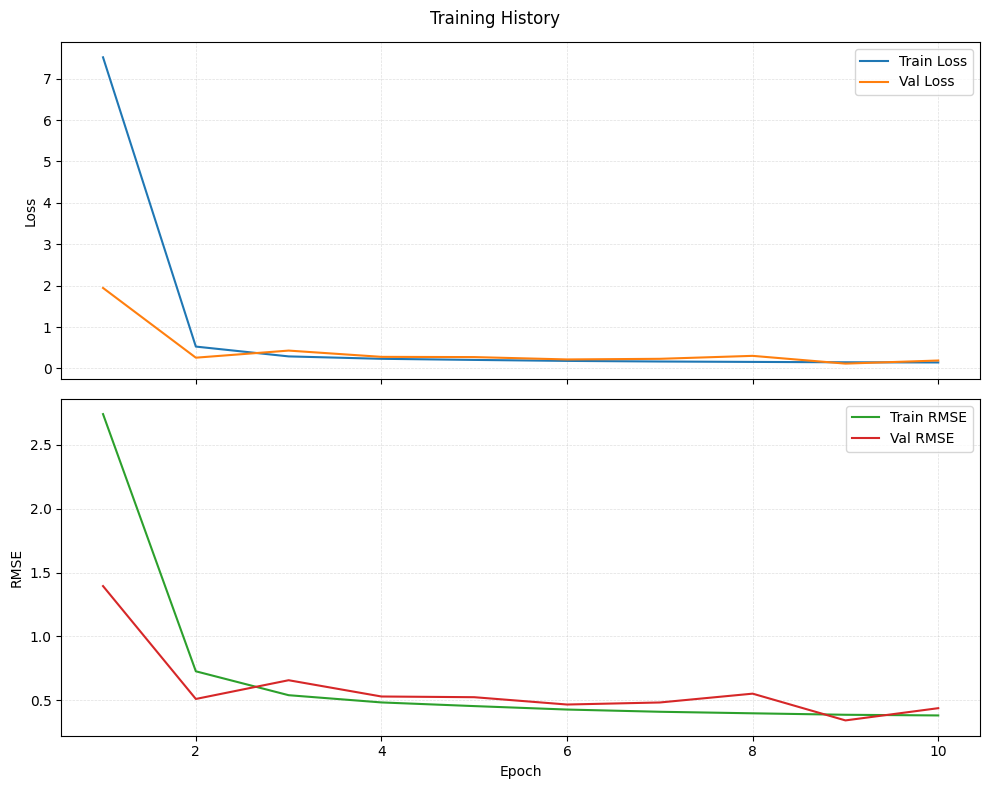

244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1266 - root_mean_squared_error: 0.3559
Test RMSE (standardized): 0.3559
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


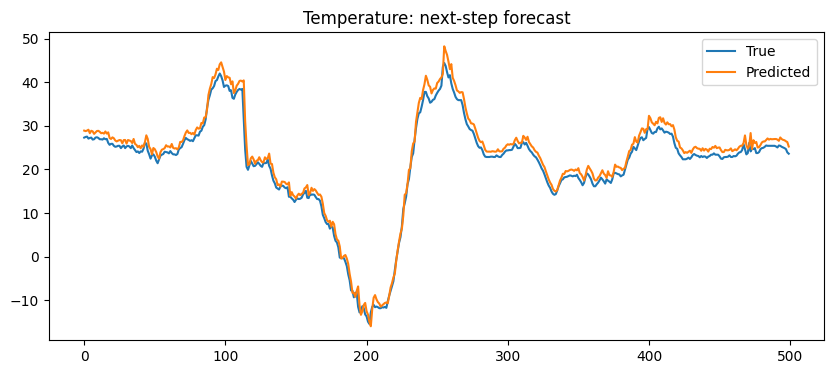

In [8]:
plot_learning(variant_history)
evaluate_test(variant_model, X_test, y_test)

6. **Altere o janelamento (valor de k) de amostras passadas usadas para a predição. O que acontece?** (Rodrigo): A seguir, reduzimos o janelamento e recriamos o modelo LSTM inicial, para avaliar o impacto na sua performance. Comparando o RMSE do grupo de dados de teste do modelo inicial (0.2918) e do modelo atual (0.2320), podemos concluir que a performance do modelo melhorou um pouco. Portanto, janelas de tempo menores parecem melhorar a performance do sistema.

(125937, 36) (125937,)
(23584, 36) (23584,)
(7838, 36) (7838,)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3936/3936 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - loss: 1.0032 - root_mean_squared_error: 1.7587 - val_loss: 0.8425 - val_root_mean_squared_error: 1.4330
Epoch 2/10
3936/3936 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - loss: 0.4374 - root_mean_squared_error: 0.7860 - val_loss: 0.6333 - val_root_mean_squared_error: 1.0843
Epoch 3/10
3936/3936 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - loss: 0.3467 - root_mean_squared_error: 0.6209 - val_loss: 0.5586 - val_root_mean_squared_error: 0.8572
Epoch 4/10
3936/3936 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - loss: 0.3009 - root_mean_squared_error: 0.5295 - val_loss: 0.6138 - val_root_mean_squared_error: 0.8873
Epoch 5/10
3936/3936 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - loss: 0.2761 - root_mean_squared_error: 0.4758 - val_loss: 0.5418 - val_root_mean_squared_error: 0.7642
Epoch 6/10
3936/3936 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - loss: 0.2574 - root_mean_squared_error: 0.4365 - val_loss: 0.4665 - val_root_mean_squared_error: 0.6732
Epoch 7/10
3936/3936 ━━━━━━━

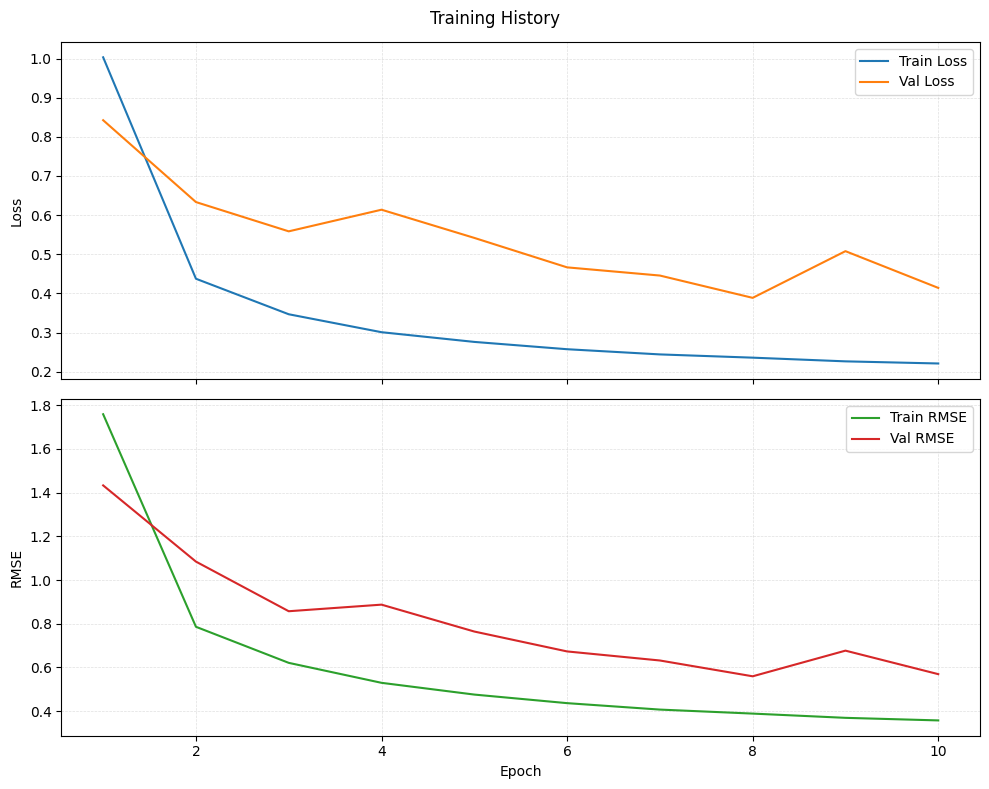

245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1474 - root_mean_squared_error: 0.2320
Test RMSE (standardized): 0.2320
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


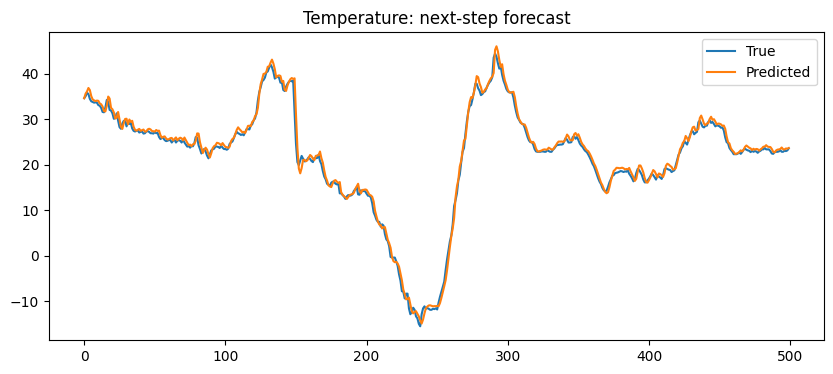

In [9]:
PAST_WINDOW = 36

X_train, y_train = make_windows(train_df, PAST_WINDOW)
X_val,   y_val   = make_windows(val_df, PAST_WINDOW)
X_test,  y_test  = make_windows(test_df, PAST_WINDOW)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

from tensorflow import keras
from keras import layers

base_model = keras.Sequential([
    layers.Input(shape=(PAST_WINDOW, 1)),
    layers.LSTM(64),                     # or layers.GRU(64)
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

base_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    loss=keras.losses.MeanAbsoluteError(reduction="sum_over_batch_size", name="mean_absolute_error", dtype=None),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

base_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
]

base_history = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=callbacks,
    shuffle=False   # keep chronological ordering
)
plot_learning(base_history)
evaluate_test(base_model, X_test, y_test)

7. **Considere somente os dados dos anos de 2015 em diante no treinamento do modelo. Como o tamanho da base de dados afeta a predição? Com base nos resultados como você interpreta a relação do passado histórico com a predição do valor atual da ação?**  (Rodrigo): A seguir, reduzimos o dataframe de 2015 adiante. Pelos resultados de RMSE e da comparação das séries temporais preditas podemos ver que a redução da base de dados prejudicou significativamente a performance de predição modelo. No meu entendimento, o treinamento do modelo com dados passados possibilita o aprendizado de tendências de longo prazo, o que facilita predições mais precisas.

            Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0 2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1 2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2 2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3 2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4 2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.7

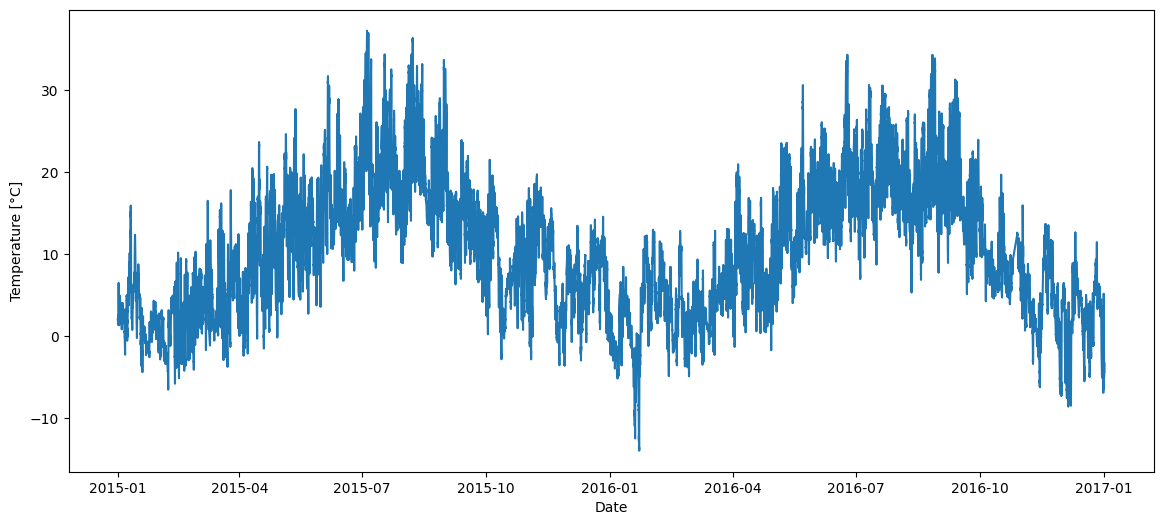

83856 15723 5241
(83784, 72) (83784,)
(15651, 72) (15651,)
(5169, 72) (5169,)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - loss: 1.2880 - root_mean_squared_error: 2.1443 - val_loss: 1.0461 - val_root_mean_squared_error: 1.7308
Epoch 2/10
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 64s 24ms/step - loss: 0.5331 - root_mean_squared_error: 0.9290 - val_loss: 0.7724 - val_root_mean_squared_error: 1.1798
Epoch 3/10
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 62s 24ms/step - loss: 0.4335 - root_mean_squared_error: 0.7684 - val_loss: 0.6911 - val_root_mean_squared_error: 1.0052
Epoch 4/10
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 64s 24ms/step - loss: 0.3789 - root_mean_squared_error: 0.6756 - val_loss: 0.5948 - val_root_mean_squared_error: 0.9979
Epoch 5/10
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 67s 25ms/step - loss: 0.3463 - root_mean_squared_error: 0.6163 - val_loss: 0.4748 - val_root_mean_squared_error: 0.8590
Epoch 6/10
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 70s 27ms/step - loss: 0.3364 - root_mean_squared_error: 0.6005 - val_loss: 0.3557 - val_root_mean_squared_error: 0.6916
Epoch 7/10
2619/2619 ━━━━━━━

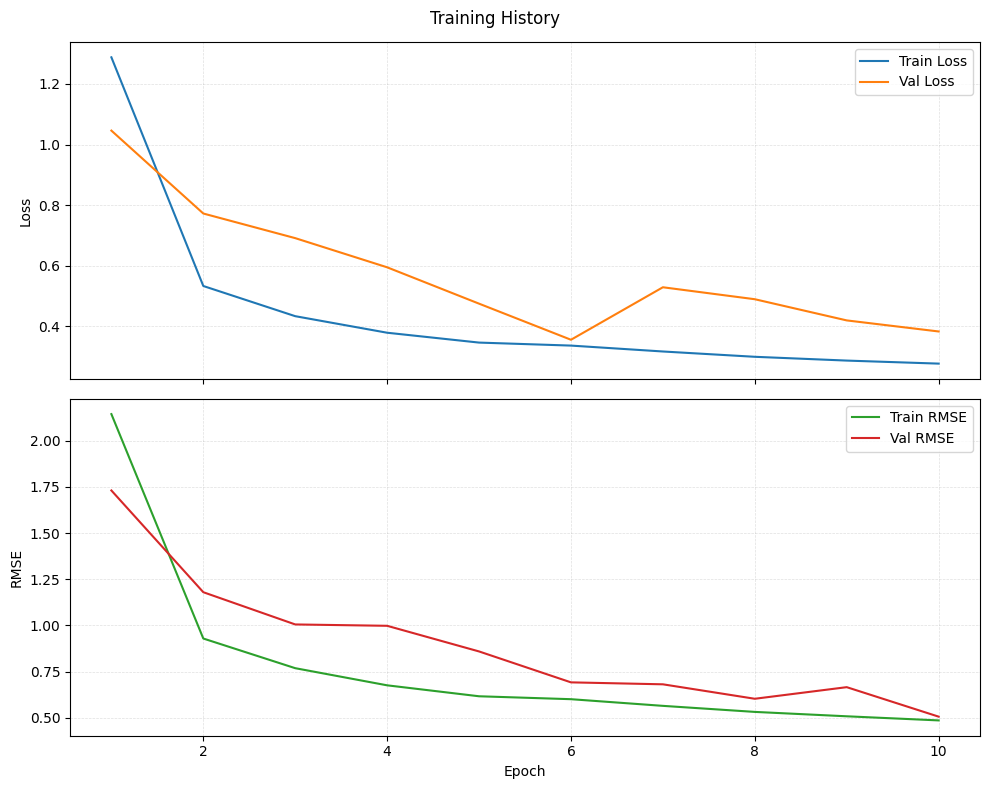

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3252 - root_mean_squared_error: 0.5934
Test RMSE (standardized): 0.5934
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


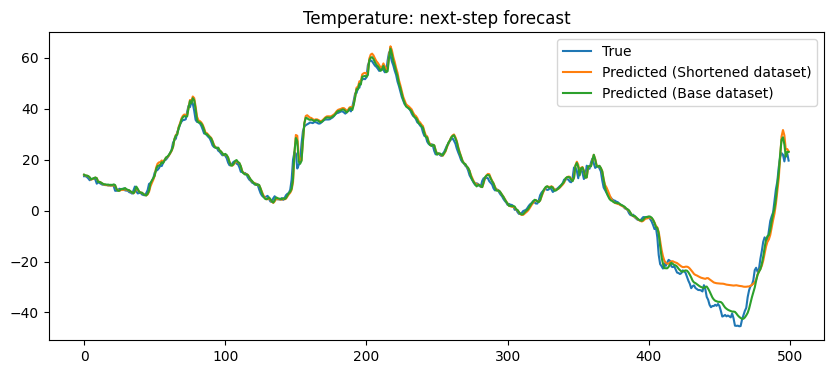

In [10]:
df = pd.read_csv("dataset/jena_climate_2009_2016.csv", parse_dates=["Date Time"])
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")

cutoff = df["Date Time"].max() - pd.DateOffset(years=2)
df_cut = df[df["Date Time"] >= cutoff]

# first rows
print(df.head())
# column types, counts
print(df.info())
# quick stats
print(df.describe())

# choose the column you need
temperature = df_cut["T (degC)"] 
time = df_cut["Date Time"] 

temp_with_time = pd.DataFrame({
    "Date Time": time,
    "Temperature": temperature,
}).set_index("Date Time")

print(temp_with_time.head())

plt.figure(figsize=(14,6))
plt.plot(temp_with_time)
plt.ylabel('Temperature [°C]')
plt.xlabel('Date')
plt.show()

n = len(df_cut)
train_end = int(n * 0.80)
val_end = train_end + int(n * 0.15)

train_df = df_cut.iloc[:train_end]
val_df = df_cut.iloc[train_end:val_end]
test_df = df_cut.iloc[val_end:]

scaler = StandardScaler()
train_series = scaler.fit_transform(train_df[["T (degC)"]])
val_series   = scaler.transform(val_df[["T (degC)"]])
test_series  = scaler.transform(test_df[["T (degC)"]])

print(len(train_df), len(val_df), len(test_df))

def make_windows(series_df, past_window=72):
    series = series_df["T (degC)"].to_numpy()
    X, y = [], []
    for i in range(len(series) - past_window):
        X.append(series[i:i+past_window])
        y.append(series[i+past_window])
    return np.array(X), np.array(y)

PAST_WINDOW = 72

X_train, y_train = make_windows(train_df, PAST_WINDOW)
X_val,   y_val   = make_windows(val_df, PAST_WINDOW)
X_test,  y_test  = make_windows(test_df, PAST_WINDOW)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

shortened_dataset_model = keras.Sequential([
    layers.Input(shape=(PAST_WINDOW, 1)),
    layers.LSTM(64),                     # or layers.GRU(64)
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

shortened_dataset_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    loss=keras.losses.MeanAbsoluteError(reduction="sum_over_batch_size", name="mean_absolute_error", dtype=None),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

shortened_dataset_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
]

shortened_dataset_history = shortened_dataset_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=callbacks,
    shuffle=False   # keep chronological ordering
)

plot_learning(shortened_dataset_history)
test_shortened_dataset_rmse = shortened_dataset_model.evaluate(X_test, y_test)
print(f"Test RMSE (standardized): {test_shortened_dataset_rmse[1]:.4f}")

# predictions back to °C
pred_scaled_shortened = shortened_dataset_model.predict(X_test)
pred_temp_shortened = scaler.inverse_transform(pred_scaled_shortened)
pred_scaled_base = base_model.predict(X_test)
pred_temp_base = scaler.inverse_transform(pred_scaled_base)

y_test_temp = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(10,4))
plt.plot(y_test_temp[:500], label="True")
plt.plot(pred_temp_shortened[:500], label="Predicted (Shortened dataset)")
plt.plot(pred_temp_base[:500], label="Predicted (Base dataset)")
plt.legend()
plt.title("Temperature: next-step forecast")
plt.show()

8. **Altere o código para que ele seja capaz de realizar a predição da temperatura para um período maior, por exemplo, o valor da temperatura prevista para a próxima hora (6 saídas – 60 minutos).** (Rodrigo): Implementamos o código para predizer 6 saídas futuras, totalizando uma previsão de 60 minutos da temperatura a diante. Os resultados mostram uma performance adequada e sem overfit.

            Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0 2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1 2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2 2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3 2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4 2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.7

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,174 (74.90 KB)

 Trainable params: 19,174 (74.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 85s 21ms/step - loss: 0.4948 - root_mean_squared_error: 0.6928 - val_loss: 0.3012 - val_root_mean_squared_error: 0.4500
Epoch 2/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 84s 21ms/step - loss: 0.1652 - root_mean_squared_error: 0.2454 - val_loss: 0.1590 - val_root_mean_squared_error: 0.2452
Epoch 3/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 84s 21ms/step - loss: 0.0961 - root_mean_squared_error: 0.1453 - val_loss: 0.0969 - val_root_mean_squared_error: 0.1447
Epoch 4/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step - loss: 0.0765 - root_mean_squared_error: 0.1151 - val_loss: 0.0826 - val_root_mean_squared_error: 0.1215
Epoch 5/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step - loss: 0.0703 - root_mean_squared_error: 0.1062 - val_loss: 0.0767 - val_root_mean_squared_error: 0.1130
Epoch 6/10
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - loss: 0.0669 - root_mean_squared_error: 0.1014 - val_loss: 0.0731 - val_root_mean_squared_error: 0.1080
Epoch 7/10
3935/3935 ━━━━━━━

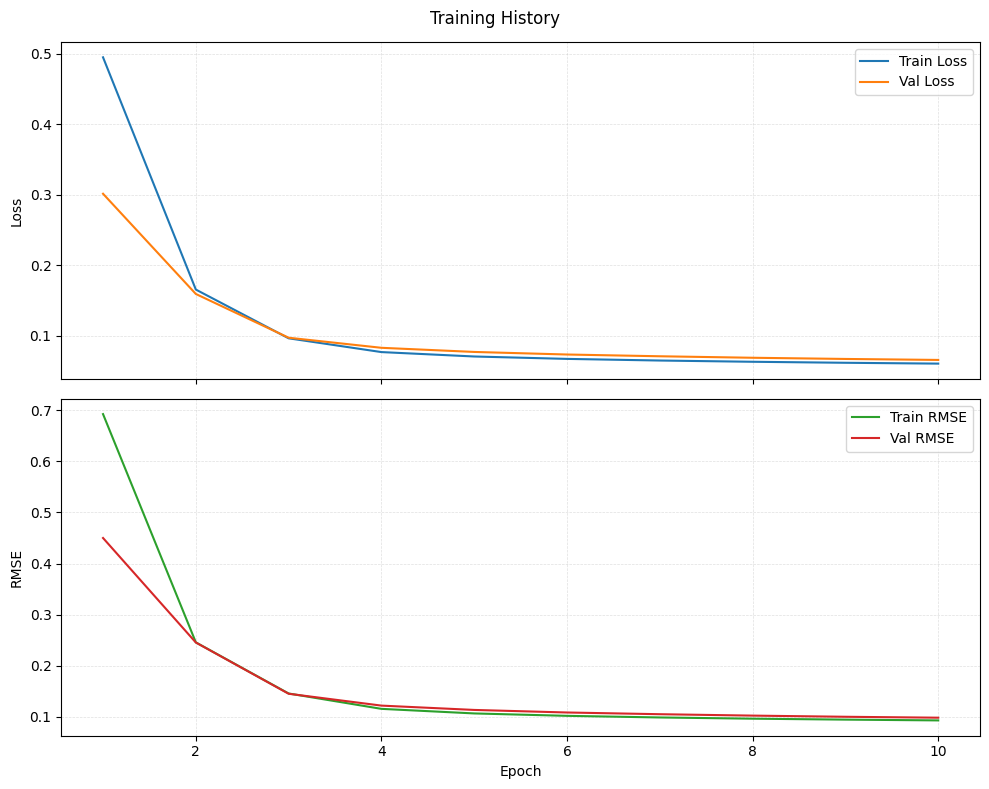

244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0628 - root_mean_squared_error: 0.0877
Test RMSE (standardized): 0.0877
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


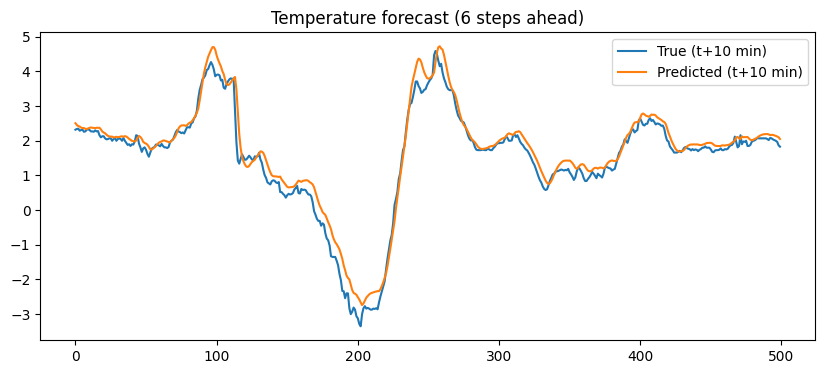

In [11]:
df = pd.read_csv("dataset/jena_climate_2009_2016.csv", parse_dates=["Date Time"])
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")

cutoff = df["Date Time"].max() - pd.DateOffset(years=3)
df_cut = df[df["Date Time"] >= cutoff]

# first rows
print(df.head())
# column types, counts
print(df.info())
# quick stats
print(df.describe())

# choose the column you need
temperature = df_cut["T (degC)"]
time = df_cut["Date Time"]

temp_with_time = pd.DataFrame({
    "Date Time": time,
    "Temperature": temperature,
}).set_index("Date Time")

n = len(df_cut)
train_end = int(n * 0.80)
val_end = train_end + int(n * 0.15)

train_df = df_cut.iloc[:train_end]
val_df = df_cut.iloc[train_end:val_end]
test_df = df_cut.iloc[val_end:]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[["T (degC)"]]).astype(np.float32)
val_scaled = scaler.transform(val_df[["T (degC)"]]).astype(np.float32)
test_scaled = scaler.transform(test_df[["T (degC)"]]).astype(np.float32)

print(len(train_df), len(val_df), len(test_df))

def make_windows(series_array, past_window=72, future_window=6):
    series = np.asarray(series_array).flatten()
    X, y = [], []
    total_window = past_window + future_window
    for start in range(len(series) - total_window + 1):
        window = series[start:start + total_window]
        X.append(window[:past_window])
        y.append(window[past_window:])
    X = np.array(X)
    y = np.array(y)
    if X.size == 0:
        return np.empty((0, past_window, 1)), np.empty((0, future_window))
    X = X[..., np.newaxis]
    return X, y

PAST_WINDOW = 72
FUTURE_WINDOW = 6

X_train, y_train = make_windows(train_scaled, past_window=PAST_WINDOW, future_window=FUTURE_WINDOW)
X_val,   y_val   = make_windows(val_scaled, past_window=PAST_WINDOW, future_window=FUTURE_WINDOW)
X_test,  y_test  = make_windows(test_scaled, past_window=PAST_WINDOW, future_window=FUTURE_WINDOW)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

base_model = keras.Sequential([
    layers.Input(shape=(PAST_WINDOW, 1)),
    layers.LSTM(64),                     # or layers.GRU(64)
    layers.Dense(32, activation="relu"),
    layers.Dense(FUTURE_WINDOW)
])

base_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    loss=keras.losses.MeanAbsoluteError(reduction="sum_over_batch_size", name="mean_absolute_error", dtype=None),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

base_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
]

base_history = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=callbacks,
    shuffle=False   # keep chronological ordering
)
plot_learning(base_history)
evaluate_test(base_model, X_test, y_test, future_window=FUTURE_WINDOW)
